# Simulating AMICI models using JAX

## Overview

This guide demonstrates how to use AMICI to export models in a format compatible with the [JAX](https://jax.readthedocs.io/en/latest/) ecosystem, enabling simulations with the [diffrax](https://docs.kidger.site/diffrax/) library. 

## Preparation

To begin, we will import a model using [PEtab](https://petab.readthedocs.io). For this demonstration, we will utilize the [Benchmark Collection](https://github.com/Benchmarking-Initiative/Benchmark-Models-PEtab), which provides a diverse set of models. For more information on importing PEtab models, refer to the corresponding [PEtab notebook](https://amici.readthedocs.io/en/latest/petab.html).

In this tutorial, we will import the Böhm model from the Benchmark Collection. Using [amici.petab_import](https://amici.readthedocs.io/en/latest/generated/amici.petab_import.html#amici.petab_import.import_petab_problem), we will load the PEtab problem. To create a  [JAXModel](https://amici.readthedocs.io/en/latest/generated/amici.jax.html#amici.jax.JAXModel) instead of a standard AMICI model, we set the `jax` parameter to `True`. As we won't use the corresponding AMICI model, we set the `compile_` to `False`.


In [1]:
from amici.petab.petab_import import import_petab_problem
import petab.v1 as petab

# Define the model name and YAML file location
model_name = "Boehm_JProteomeRes2014"
yaml_url = (
    f"https://raw.githubusercontent.com/Benchmarking-Initiative/Benchmark-Models-PEtab/"
    f"master/Benchmark-Models/{model_name}/{model_name}.yaml"
)

# Load the PEtab problem from the YAML file
petab_problem = petab.Problem.from_yaml(yaml_url)

# Import the PEtab problem as a JAX-compatible AMICI model
jax_model = import_petab_problem(
    petab_problem,
    compile_=False,  # do not compile regular amici model
    verbose=False,  # no text output
    jax=True,  # return jax model
)

## Simulation

In principle, we can already use this model for simulation using the [simulate_condition](https://amici.readthedocs.io/en/latest/generated/amici.jax.html#amici.jax.JAXModel.simulate_condition) method. However, this approach can be cumbersome as timepoints, data etc. need to be specified manually. Instead, we process the PEtab problem into a [JAXProblem](https://amici.readthedocs.io/en/latest/generated/amici.jax.html#amici.jax.JAXProblem), which enables efficient simulation using [amici.jax.run_simulations]((https://amici.readthedocs.io/en/latest/generated/amici.jax.html#amici.jax.run_simulations).

In [2]:
from amici.jax import JAXProblem, run_simulations

# Create a JAXProblem from the JAX model and PEtab problem
jax_problem = JAXProblem(jax_model, petab_problem)

# Run simulations and compute the log-likelihood
llh, results = run_simulations(jax_problem)

This simulates the model for all conditions using the nominal parameter values. Simple, right? Now, let’s take a look at the simulation results.

In [3]:
# Define the simulation condition
simulation_condition = ("model1_data1",)

# Access the results for the specified condition
results[simulation_condition]

(Array(nan, dtype=float32),
 {'stats_dyn': {'max_steps': 1024,
   'num_accepted_steps': Array(778, dtype=int32, weak_type=True),
   'num_rejected_steps': Array(246, dtype=int32, weak_type=True),
   'num_steps': Array(1024, dtype=int32, weak_type=True)},
  'stats_posteq': None,
  'stats_preeq': None,
  'ts': Array([  0. ,   0. ,   0. ,   2.5,   2.5,   2.5,   5. ,   5. ,   5. ,
          10. ,  10. ,  10. ,  15. ,  15. ,  15. ,  20. ,  20. ,  20. ,
          30. ,  30. ,  30. ,  40. ,  40. ,  40. ,  50. ,  50. ,  50. ,
          60. ,  60. ,  60. ,  80. ,  80. ,  80. , 100. , 100. , 100. ,
         120. , 120. , 120. , 160. , 160. , 160. , 200. , 200. , 200. ,
         240. , 240. , 240. ], dtype=float32),
  'x': Array([[143.8668,  63.7332,   0.    ,   0.    ,   0.    ,   0.    ,
            0.    ,   0.    ],
         [143.8668,  63.7332,   0.    ,   0.    ,   0.    ,   0.    ,
            0.    ,   0.    ],
         [143.8668,  63.7332,   0.    ,   0.    ,   0.    ,   0.    ,
         

Unfortunately, the simulation failed! As seen in the output, the simulation broke down after the initial timepoint, indicated by the `inf` values in the state variables `results[simulation_condition][1].x` and the `nan` likelihood value. A closer inspection of this variable provides additional clues about what might have gone wrong.

The issue stems from using single precision, as indicated by the `float32` dtype of state variables. Single precision is generally a [bad idea](https://docs.kidger.site/diffrax/examples/stiff_ode/) for stiff systems like the Böhm model. Let’s retry the simulation with double precision.

In [4]:
import jax

# Enable double precision in JAX
jax.config.update("jax_enable_x64", True)

# Re-run simulations with double precision
llh, results = run_simulations(jax_problem)

results

{('model1_data1',): (Array(-138.22199834, dtype=float64),
  {'stats_dyn': {'max_steps': 1024,
    'num_accepted_steps': Array(125, dtype=int64, weak_type=True),
    'num_rejected_steps': Array(7, dtype=int64, weak_type=True),
    'num_steps': Array(132, dtype=int64, weak_type=True)},
   'stats_posteq': None,
   'stats_preeq': None,
   'ts': Array([  0. ,   0. ,   0. ,   2.5,   2.5,   2.5,   5. ,   5. ,   5. ,
           10. ,  10. ,  10. ,  15. ,  15. ,  15. ,  20. ,  20. ,  20. ,
           30. ,  30. ,  30. ,  40. ,  40. ,  40. ,  50. ,  50. ,  50. ,
           60. ,  60. ,  60. ,  80. ,  80. ,  80. , 100. , 100. , 100. ,
          120. , 120. , 120. , 160. , 160. , 160. , 200. , 200. , 200. ,
          240. , 240. , 240. ], dtype=float64),
   'x': Array([[1.43866806e+02, 6.37332001e+01, 0.00000000e+00, 0.00000000e+00,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [1.43866806e+02, 6.37332001e+01, 0.00000000e+00, 0.00000000e+00,
           0.000

Success! The simulation completed successfully, and we can now plot the resulting state trajectories.

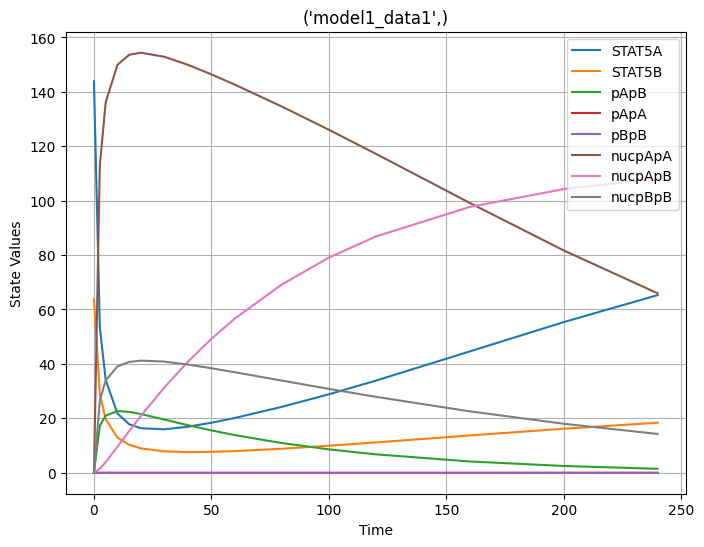

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np


def plot_simulation(results):
    """
    Plot the state trajectories from the simulation results.

    Parameters:
        results (dict): Simulation results from run_simulations.
    """
    # Extract the simulation results for the specific condition
    sim_results = results[simulation_condition][1]

    # Create a new figure for the state trajectories
    plt.figure(figsize=(8, 6))
    for idx in range(sim_results["x"].shape[1]):
        time_points = np.array(sim_results["ts"])
        state_values = np.array(sim_results["x"][:, idx])
        plt.plot(time_points, state_values, label=jax_model.state_ids[idx])

    # Add labels, legend, and grid
    plt.xlabel("Time")
    plt.ylabel("State Values")
    plt.title(simulation_condition)
    plt.legend()
    plt.grid(True)
    plt.show()


# Plot the simulation results
plot_simulation(results)

`run_simulations` enables users to specify the simulation conditions to be executed. For more complex models, this allows for restricting simulations to a subset of conditions. Since the Böhm model includes only a single condition, we demonstrate this functionality by simulating no condition at all.

In [6]:
llh, results = run_simulations(jax_problem, simulation_conditions=tuple())
results

{}

## Updating Parameters

As next step, we will update the parameter values used for simulation. However, if we attempt to directly modify the values in `JAXModel.parameters`, we encounter a `FrozenInstanceError`.

In [7]:
from dataclasses import FrozenInstanceError
import jax

# Generate random noise to update the parameters
noise = (
    jax.random.normal(
        key=jax.random.PRNGKey(0), shape=jax_problem.parameters.shape
    )
    / 10
)

# Attempt to update the parameters
try:
    jax_problem.parameters += noise
except FrozenInstanceError as e:
    print("Error:", e)

Error: cannot assign to field 'parameters'


The root cause of this error lies in the fact that, to enable autodiff, direct modifications of attributes are not allowed in [equinox](https://docs.kidger.site/equinox/), which AMICI utilizes under the hood. Consequently, attributes of instances like `JAXModel` or `JAXProblem` cannot be updated directly — this is the price we have to pay for autodiff.

However, `JAXProblem` provides a convenient method called [update_parameters](https://amici.readthedocs.io/en/latest/generated/amici.jax.html#amici.jax.JAXProblem.update_parameters). The caveat is that this method creates a new JAXProblem instance instead of modifying the existing one.

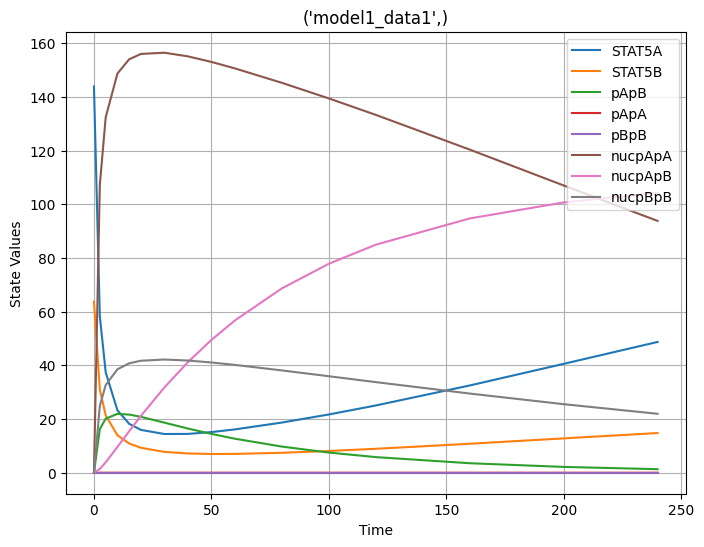

In [8]:
# Update the parameters and create a new JAXProblem instance
jax_problem = jax_problem.update_parameters(jax_problem.parameters + noise)

# Run simulations with the updated parameters
llh, results = run_simulations(jax_problem)

# Plot the simulation results
plot_simulation(results)

## Computing Gradients

Similar to updating attributes, computing gradients in the JAX ecosystem can feel a bit unconventional if you’re not familiar with the JAX ecosysmt. JAX offers [powerful automatic differentiation](https://jax.readthedocs.io/en/latest/automatic-differentiation.html) through the `jax.grad` function. However, to use `jax.grad` with `JAXProblem`, we need to specify which parts of the `JAXProblem` should be treated as static.

In [9]:
try:
    # Attempt to compute the gradient of the run_simulations function
    jax.grad(run_simulations, has_aux=True)(jax_problem)
except TypeError as e:
    print("Error:", e)

Error: Argument 'ParameterMappingForCondition(map_sim_var={'Epo_degradation_BaF3': 'Epo_degradation_BaF3', 'k_exp_hetero': 'k_exp_hetero', 'k_exp_homo': 'k_exp_homo', 'k_imp_hetero': 'k_imp_hetero', 'k_imp_homo': 'k_imp_homo', 'k_phos': 'k_phos', 'ratio': 0.693, 'specC17': 0.107, 'noiseParameter1_pSTAT5A_rel': 'sd_pSTAT5A_rel', 'noiseParameter1_pSTAT5B_rel': 'sd_pSTAT5B_rel', 'noiseParameter1_rSTAT5A_rel': 'sd_rSTAT5A_rel'},scale_map_sim_var={'Epo_degradation_BaF3': 'log10', 'k_exp_hetero': 'log10', 'k_exp_homo': 'log10', 'k_imp_hetero': 'log10', 'k_imp_homo': 'log10', 'k_phos': 'log10', 'ratio': 'lin', 'specC17': 'lin', 'noiseParameter1_pSTAT5A_rel': 'log10', 'noiseParameter1_pSTAT5B_rel': 'log10', 'noiseParameter1_rSTAT5A_rel': 'log10'},map_preeq_fix={},scale_map_preeq_fix={},map_sim_fix={},scale_map_sim_fix={})' of type <class 'amici.petab.parameter_mapping.ParameterMappingForCondition'> is not a valid JAX type.


Fortunately, `equinox` simplifies this process by offering [filter_grad](https://docs.kidger.site/equinox/api/transformations/#equinox.filter_grad), which enables autodiff functionality that is compatible with `JAXProblem` and, in theory, also with `JAXModel`.

In [10]:
import equinox as eqx

# Compute the gradient using equinox's filter_grad, preserving auxiliary outputs
grad, _ = eqx.filter_grad(run_simulations, has_aux=True)(jax_problem)

Functions transformed by `filter_grad` return gradients that share the same structure as the first argument (unless specified otherwise). This allows us to access the gradient with respect to the parameters attribute directly `via grad.parameters`.

In [11]:
grad.parameters

Array([ 2.39759630e+01, -1.36704159e-01,  1.33625245e+01,  3.25229304e+01,
        4.88660333e-05,  5.39482681e+01, -5.13624151e+00, -2.90885864e-02,
        6.08639536e+01], dtype=float64)

Attributes for which derivatives cannot be computed (typically anything that is not a [jax.numpy.array](https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.array.html)) are automatically set to `None`.

In [12]:
grad

JAXProblem(
  parameters=f64[9],
  model=JAXModel_Boehm_JProteomeRes2014(api_version='0.0.1'),
  _parameter_mappings={'model1_data1': None},
  _measurements={('model1_data1',): (f64[3], f64[45], f64[0], f64[48], None)},
  _petab_problem=None
)

Observant readers may notice that the gradient above appears to include numeric values for derivatives with respect to some measurements. However, `simulation_conditions` internally disables gradient computations using `jax.lax.stop_gradient`, resulting in these values being zeroed out.

In [13]:
grad._measurements[simulation_condition]

(Array([0., 0., 0.], dtype=float64),
 Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float64),
 Array([], shape=(0,), dtype=float64),
 Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float64),
 None)

However, we can compute derivatives with respect to data elements using `JAXModel.simulate_condition`. In the example below, we differentiate the observables `y` (specified by passing `y` to the `ret` argument) with respect to the timepoints at which the model outputs are computed after the solving the differential equation. While this might not be particularly practical, it serves as an nice illustration of the power of automatic differentiation.

In [14]:
import jax.numpy as jnp
import diffrax

# Define the simulation condition
simulation_condition = ("model1_data1",)

# Load condition-specific data
ts_preeq, ts_dyn, ts_posteq, my, iys = jax_problem._measurements[
    simulation_condition
]

# Load parameters for the specified condition
p = jax_problem.load_parameters(simulation_condition[0])
# Disable preequilibration
p_preeq = jnp.array([])


# Define a function to compute the gradient with respect to dynamic timepoints
@eqx.filter_jacfwd
def grad_ts_dyn(tt):
    return jax_problem.model.simulate_condition(
        p=p,
        p_preeq=p_preeq,
        ts_preeq=ts_preeq,
        ts_dyn=tt,
        ts_posteq=ts_posteq,
        my=jnp.array(my),
        iys=jnp.array(iys),
        solver=diffrax.Kvaerno5(),
        controller=diffrax.PIDController(atol=1e-8, rtol=1e-8),
        max_steps=2**10,
        adjoint=diffrax.DirectAdjoint(),
        ret="y",  # Return observables
    )[0]


# Compute the gradient with respect to `ts_dyn`
g = grad_ts_dyn(ts_dyn)
g

Array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.30871686e-01,  0.00000000e+00, -3.80465095e-11],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00, -2.69250222e-01, -7.93596886e-11],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00, -2.29968854e-02]],      dtype=float64)

## Compilation & Profiling

To maximize performance with JAX, code should be just-in-time (JIT) compiled. This can be achieved using the `jax.jit` or `equinox.filter_jit` decorators. While JIT compilation introduces some overhead during the first function call, it significantly improves performance for subsequent calls. To demonstrate this, we will first clear the JIT cache and then profile the execution.

In [15]:
from time import time

# Clear JAX caches to ensure a fresh start
jax.clear_caches()

# Define a JIT-compiled gradient function with auxiliary outputs
gradfun = eqx.filter_jit(eqx.filter_grad(run_simulations, has_aux=True))

In [16]:
# Measure the time taken for the first function call (including compilation)
start = time()
run_simulations(jax_problem)
print(f"Function compilation time: {time() - start:.2f} seconds")

# Measure the time taken for the gradient computation (including compilation)
start = time()
gradfun(jax_problem)
print(f"Gradient compilation time: {time() - start:.2f} seconds")

Function compilation time: 2.53 seconds
Gradient compilation time: 6.21 seconds


In [17]:
%%timeit
run_simulations(
    jax_problem,
    controller=diffrax.PIDController(
        rtol=1e-8,  # same as amici default
        atol=1e-16,  # same as amici default
        pcoeff=0.4,  # recommended value for stiff systems
        icoeff=0.3,  # recommended value for stiff systems
        dcoeff=0.0,  # recommended value for stiff systems
    ),
)

16.6 ms ± 609 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
%%timeit 
gradfun(
    jax_problem,
    controller=diffrax.PIDController(
        rtol=1e-8,  # same as amici default
        atol=1e-16,  # same as amici default
        pcoeff=0.4,  # recommended value for stiff systems
        icoeff=0.3,  # recommended value for stiff systems
        dcoeff=0.0,  # recommended value for stiff systems
    ),
)

39.8 ms ± 854 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
from amici.petab import simulate_petab
import amici

# Import the PEtab problem as a standard AMICI model
amici_model = import_petab_problem(
    petab_problem, compile_=True, verbose=False, jax=False
)

# Configure the solver with appropriate tolerances
solver = amici_model.getSolver()
solver.setAbsoluteTolerance(1e-8)
solver.setRelativeTolerance(1e-8)

# Prepare the parameters for the simulation
problem_parameters = dict(
    zip(jax_problem.parameter_ids, jax_problem.parameters)
)

In [20]:
# Profile simulation only
solver.setSensitivityOrder(amici.SensitivityOrder.none)

In [21]:
%%timeit 
simulate_petab(
    petab_problem,
    amici_model,
    solver=solver,
    problem_parameters=problem_parameters,
    scaled_parameters=True,
    scaled_gradients=True,
)

26.1 ms ± 2.71 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [22]:
# Profile gradient computation using forward sensitivity analysis
solver.setSensitivityOrder(amici.SensitivityOrder.first)
solver.setSensitivityMethod(amici.SensitivityMethod.forward)

In [23]:
%%timeit 
simulate_petab(
    petab_problem,
    amici_model,
    solver=solver,
    problem_parameters=problem_parameters,
    scaled_parameters=True,
    scaled_gradients=True,
)

29.1 ms ± 1.82 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [24]:
# Profile gradient computation using adjoint sensitivity analysis
solver.setSensitivityOrder(amici.SensitivityOrder.first)
solver.setSensitivityMethod(amici.SensitivityMethod.adjoint)

In [25]:
%%timeit 
simulate_petab(
    petab_problem,
    amici_model,
    solver=solver,
    problem_parameters=problem_parameters,
    scaled_parameters=True,
    scaled_gradients=True,
)

39.3 ms ± 1.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
